# Setup

In [2]:
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch
import numpy as np

import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path + "/utils")

from utils.partialjaclib import *

set_matplotlib_formats("pdf", "svg")

USE_GPU = True

dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif USE_GPU == True and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device("cpu")
print("using device:", device)



using device: cpu


/var/folders/_k/d3_t098562j1mrxkzvt5b58h0000gn/T/ipykernel_72037/1622160727.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


In [3]:
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.33, 0.5, 0.5],
                   [0.66, 1.0, 1.0],
                   [1.0, 1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.33, 0.5, 0.5],
                   [0.67, 1.0, 1.0],
                   [1.0, 0.0, 0.0]],
         'blue':  [[0.0,  1.0, 1.0],
                   [0.33, 1.0, 1.0],
                   [0.67, 1.0, 1.0],
                   [1.0,  0.0, 0.0]]}

cdict2 = {'red':   [[0.0,  0.0, 0.0],
                   [0.33, 1.0, 1.0],
                   [0.67, 1.0, 1.0],
                   [1.0, 1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.33, 1.0, 1.0],
                   [0.67, 0.0, 0.0],
                   [1.0, 0.0, 0.0]],
         'blue':  [[0.0,  1., 1.0],
                   [0.33, 1.0, 1.0],
                   [0.67, 0.0, 0.0],
                   [1.0,  0.0, 0.0]]}

newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
newcmp2 = LinearSegmentedColormap('testCmap', segmentdata=cdict2, N=256)

# Phase Diagram (Fig 1)

$\mu=0.0$ examples

In [4]:
batch_size = 1
n_channel = 1
img_size = 28
xr = torch.normal(0, 1.0, (batch_size, n_channel, img_size, img_size)).to(device=device)
xr = Variable(xr, requires_grad=True)
xr.shape

torch.Size([1, 1, 28, 28])

In [5]:
wvars = np.arange(0.0, 4.1, 0.5)
bvars = np.arange(0.0, 2.1, 0.2)
acts = ['ReLU', 'erf', 'GELU']
chijs = np.zeros((len(acts), wvars.shape[0], bvars.shape[0]))

act = 'ReLU'
width = 500
out_size = 10
n_hidden = 48
n_proj = 5
n_ave = 3
bias = True

for k, act in enumerate(acts):
    for _ in range(n_ave):
        for i in range(wvars.shape[0]):
            for j in range(bvars.shape[0]):
                model = Fcc_Standard(n_channel * img_size**2, width, out_size, n_hidden, wvars[i]**0.5, bvars[j]**0.5, act, bias=True).to(device=device)
                fhook = fwd_hook(model, n_hidden-2)
                bhook = bwd_hook(model, n=n_hidden-3)
                out = model(xr)
                chijs[k, i, j] += partialj(fhook, bhook, n_proj, device)

chijs = chijs / n_ave

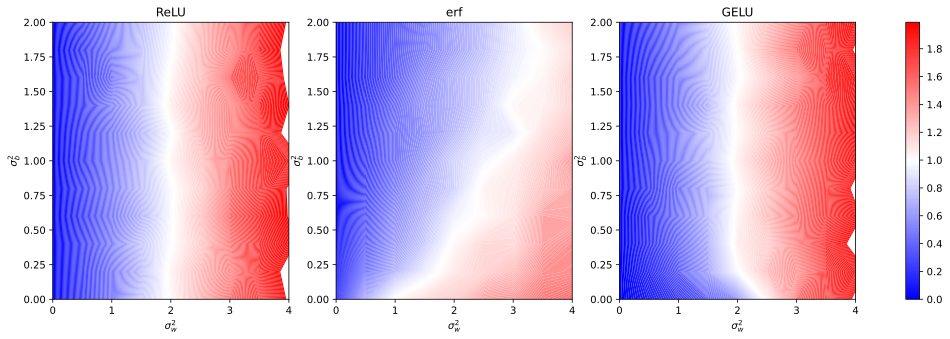

In [6]:
levels = np.linspace(0.0, 2.0, 200)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

csf0 = axs[0].contourf(wvars, bvars, chijs[0].T, cmap='bwr', levels=levels)

axs[0].set_title('ReLU')
axs[0].set_xlabel('$\\sigma_w^2$')
axs[0].set_ylabel('$\\sigma_b^2$')

csf1 = axs[1].contourf(wvars, bvars, chijs[1].T, cmap='bwr', levels=levels)

axs[1].set_title('erf')
axs[1].set_xlabel('$\\sigma_w^2$')
axs[1].set_ylabel('$\\sigma_b^2$')

csf2 = axs[2].contourf(wvars, bvars, chijs[2].T, cmap='bwr', levels=levels)

axs[2].set_title('GELU')
axs[2].set_xlabel('$\\sigma_w^2$')
axs[2].set_ylabel('$\\sigma_b^2$')

fig.colorbar(csf0, ax=axs, format='%.1f')
plt.show()

$\mu=0.9$ examples

In [7]:
wvars = np.arange(0.0, 4.1, 0.5)
bvars = np.arange(0.0, 2.1, 0.2)
acts = ['ReLU', 'erf', 'GELU']
chijs = np.zeros((len(acts), wvars.shape[0], bvars.shape[0]))

mu = 0.9
act = 'ReLU'
width = 500
out_size = 10
n_hidden=48
n_proj = 5
n_ave = 3
bias = True


for k, act in enumerate(acts):
    for _ in range(n_ave):
        for i in range(wvars.shape[0]):
            for j in range(bvars.shape[0]):
                model = ResFcc(n_channel * img_size**2, width, out_size, n_hidden, wvars[i]**0.5, bvars[j]**0.5, act, mu=mu, bias=True).to(device=device)
                fhook = resblock_fwd_hook(model, n_hidden-2)
                bhook = resblock_bwd_hook(model, n_hidden-3)
                out = model(xr)
                chijs[k, i, j] += partialj(fhook, bhook, n_proj, device)

chijs = chijs / n_ave

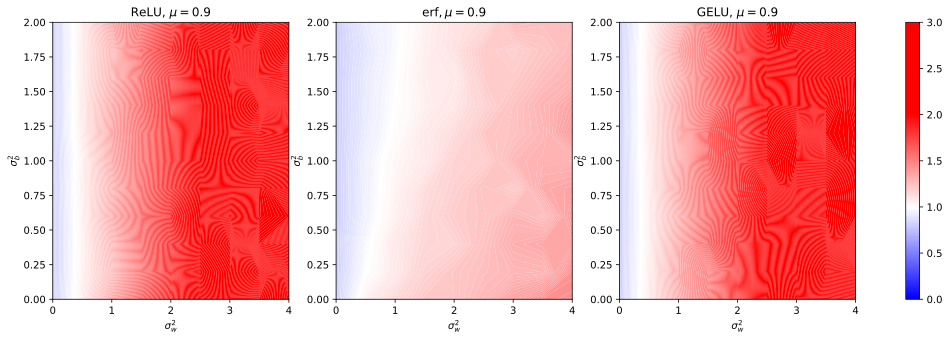

In [8]:
levels = np.linspace(0.0, 3.0, 300)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

csf0 = axs[0].contourf(wvars, bvars, chijs[0].T, cmap=newcmp2, levels=levels)

axs[0].set_title('ReLU, $\\mu=0.9$')
axs[0].set_xlabel('$\\sigma_w^2$')
axs[0].set_ylabel('$\\sigma_b^2$')

csf1 = axs[1].contourf(wvars, bvars, chijs[1].T, cmap=newcmp2, levels=levels)

axs[1].set_title('erf$, \\mu=0.9$')
axs[1].set_xlabel('$\\sigma_w^2$')
axs[1].set_ylabel('$\\sigma_b^2$')

csf2 = axs[2].contourf(wvars, bvars, chijs[2].T, cmap=newcmp2, levels=levels)

axs[2].set_title('GELU, $\\mu=0.9$')
axs[2].set_xlabel('$\\sigma_w^2$')
axs[2].set_ylabel('$\\sigma_b^2$')

fig.colorbar(csf0, ax=axs, format='%.1f', ticks=[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
plt.show()

LN-ReLU $\mu=\{0.0, 0.9, 1.0\}$ examples

In [9]:
batch_size = 1
n_channel = 1
img_size = 28
xr = torch.normal(0, 1.0, (batch_size, n_channel, img_size, img_size)).to(device=device)
xr = Variable(xr, requires_grad=True)
xr.shape

torch.Size([1, 1, 28, 28])

In [10]:
wvars = np.arange(0.0, 5.1, 0.5)
bvars = np.arange(0.0, 2.1, 0.2)
mus = [0.0, 0.9, 1.0]
chijs = np.zeros((len(mus), wvars.shape[0], bvars.shape[0]))

act = 'ReLU'
width = 500
out_size = 10
n_hidden = 48
n_proj = 5
n_ave = 2
bias = True

for k, mu in enumerate(mus):
    for _ in range(n_ave):
        for i in range(wvars.shape[0]):
            for j in range(bvars.shape[0]):
                model = ResLNFcc(n_channel * img_size**2, width, out_size, n_hidden, wvars[i]**0.5, bvars[j]**0.5, act, mu=mu, bias=True).to(device=device)
                fhook = reslnblock_fwd_hook(model, n_hidden-2)
                bhook = reslnblock_bwd_hook(model, n_hidden-3)
                out = model(xr)
                chijs[k, i, j] += partialj(fhook, bhook, n_proj, device)

chijs = chijs / n_ave

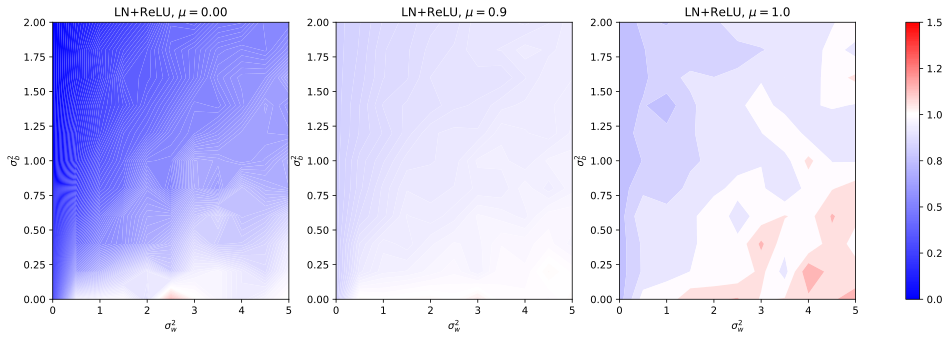

In [11]:
levels0 = np.linspace(0.0, 1.5, 150)
levels1 = np.linspace(0.0, 1.5, 150)
levels2 = np.linspace(0.95, 1.05, 20)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

csf0 = axs[0].contourf(wvars, bvars, chijs[0].T, cmap=newcmp, levels=levels0)

axs[0].set_title('LN+ReLU, $\mu=${:.2f}'.format(mus[0]))
axs[0].set_xlabel('$\\sigma_w^2$')
axs[0].set_ylabel('$\\sigma_b^2$')

csf1 = axs[1].contourf(wvars, bvars, chijs[1].T, cmap=newcmp, levels=levels1)

axs[1].set_title('LN+ReLU, $\mu=${:.1f}'.format(mus[1]))
axs[1].set_xlabel('$\\sigma_w^2$')
axs[1].set_ylabel('$\\sigma_b^2$')

csf2 = axs[2].contourf(wvars, bvars, chijs[2].T, cmap=newcmp, levels=levels2)

axs[2].set_title('LN+ReLU, $\mu=${:.1f}'.format(mus[2]))
axs[2].set_xlabel('$\\sigma_w^2$')
axs[2].set_ylabel('$\\sigma_b^2$')

fig.colorbar(csf0, ax=axs, format='%.1f', ticks=[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
plt.show()

# Phase Diagram (Fig 3)

Mixer $\mu = \{ 0.5, 1.0 \}$

In [12]:
img_size = 32
patch_size = 2
h_size = 128
tokens_mlp_dim = 256
channels_mlp_dim = 256
n_classes = 10

In [13]:
batch_size = 1
n_channel = 3
xr = torch.normal(0, 1.0, (batch_size, n_channel, img_size, img_size)).to(device=device)
xr = Variable(xr, requires_grad=True)
xr.shape


torch.Size([1, 3, 32, 32])

In [14]:
wvars = np.arange(0.0, 5.1, 0.5)
bvars = np.arange(0.0, 5.1, 0.5)
mus = [0.5, 1.0]
chijs = np.zeros((len(mus), wvars.shape[0], bvars.shape[0]))

act = 'GELU'
out_size = 10
n_blocks = 50
n_proj = 5
l = n_blocks - 3
n_ave = 3
bias = True

for k, mu in enumerate(mus):
    for _ in range(n_ave):
        for i in range(wvars.shape[0]):
            for j in range(bvars.shape[0]):
                model = MlpMixer(img_size, patch_size, h_size, tokens_mlp_dim, channels_mlp_dim, n_classes, n_blocks, wvars[i] ** 0.5, bvars[j] ** 0.5, mu, act, bias=bias).to(device=device)
                fhook = mixerblock_fwd_hook(model, n=l)
                bhook = mixerblock_bwd_hook(model, n=l - 1)
                out = model(xr)
                chijs[k, i, j] += partialj(fhook, bhook, n_proj, device)

chijs = chijs / n_ave

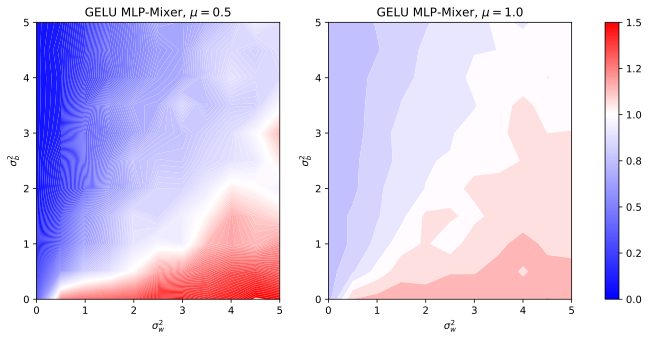

In [15]:
levels0 = np.linspace(0.0, 1.5, 150)
levels1 = np.linspace(0.95, 1.05, 20)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

csf0 = axs[0].contourf(wvars, bvars, chijs[0].T, cmap=newcmp, levels=levels0)

axs[0].set_title('GELU MLP-Mixer, $\mu=${:.1f}'.format(mus[0]))
axs[0].set_xlabel('$\\sigma_w^2$')
axs[0].set_ylabel('$\\sigma_b^2$')

csf1 = axs[1].contourf(wvars, bvars, chijs[1].T, cmap=newcmp, levels=levels1)

axs[1].set_title('GELU MLP-Mixer, $\mu=${:.1f}'.format(mus[1]))
axs[1].set_xlabel('$\\sigma_w^2$')
axs[1].set_ylabel('$\\sigma_b^2$')

fig.colorbar(csf0, ax=axs, format='%.1f', ticks=[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
plt.show()